In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import glob
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED/')
from util import derive_var,read_and_proc,ts_models,benchmark
import properscoring as ps
from copy import deepcopy
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
import random

# Basic Settings

In [2]:
# Setting up seed so that results are reproducible
benchmark.setup_seed(8888)

# Setting up path where things are stored
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'

In [3]:
# Read in processed data
storedata,store_notensor = {},{}
for i in tqdm(range(0,3)):
    storedata[i] = benchmark.prepare_tensors('../processed/maria_store',i,23,'No')
    store_notensor[i] = benchmark.prepare_tensors('../processed/maria_store',i,23,'Yes')

  0%|          | 0/3 [00:00<?, ?it/s]

# Read in model, make predictions, and calculate performance metrics

## VAE

In [4]:
# Basic Settings for the wrapper to get the full model predictions and basic performance metrics
losscoeffs = [0.65,0.7,0.75,0.8,0.85,0.95] #lambda term in the loss function
numsplit = 3 #Number of splits we have trained
trailnums = 30 #Multiple iteration of model predictions are saved to get the prediction spread
seeds = np.random.randint(0, 500,size=20) #Choose 20 seeds randomly to run model inference

# Save results in a dictionary
# Performance metrics to be saved: CRPS score; Save prediction spread
seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='../processed/maria_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Choose the best model

In [77]:
# Get the SSREL score for all the models, with different seeds, split, and initialization
allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(3):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [benchmark.get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='train',meancat='meantrains') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)
    
# Save the minimum SSREL score for models with different splits and initialization    
ssRels_array = np.zeros((3,9))
for i in (range(3)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.85][i][j]['ssRel'] for k in range(20)]).min()

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
# Find the split and initialization that produce the lowest SSREL score
minsplit,minmodel = np.argwhere(ssRels_array == np.min(ssRels_array))[0][0],np.argwhere(ssRels_array == np.min(ssRels_array))[0][1]

# Find the seed number that produces the lowest SSREL score for a given split and initialization
minseed = np.asarray([allsave[k][0.85][minsplit][minmodel]['ssRel'] for k in range(20)]).argmin()

# Plotting

In [79]:
# Read in the best model
bestmodel = seeds_store[seeds[minseed]][0.85][minsplit]['models'][minmodel]

# Calculate the effective weights (see SI for details); -40 and -20 are the indices of the longwave PCs in the input data
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW',[-20,-10])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW',[-20,-10])

# Calculate the overall bias (see SI for details)
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[minsplit]['train'][0],bestmodel,[-20,-10])

# PCA objects produced by the scikit-learn library
pcalw = read_and_proc.depickle('../processed/maria_store/pca/lw/'+str(minsplit)+'/PCA3D_corr.pkg'),read_and_proc.depickle('../processed/maria_store/pca/sw/'+str(minsplit)+'/PCA3D_corr.pkg')

# Weights to get the $\Pi_{\mu, LW}$, $\Pi_{\mu, SW}$ structures from the SI equations
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW',[-20,-10])
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW',[-20,-10])

## Figure 2

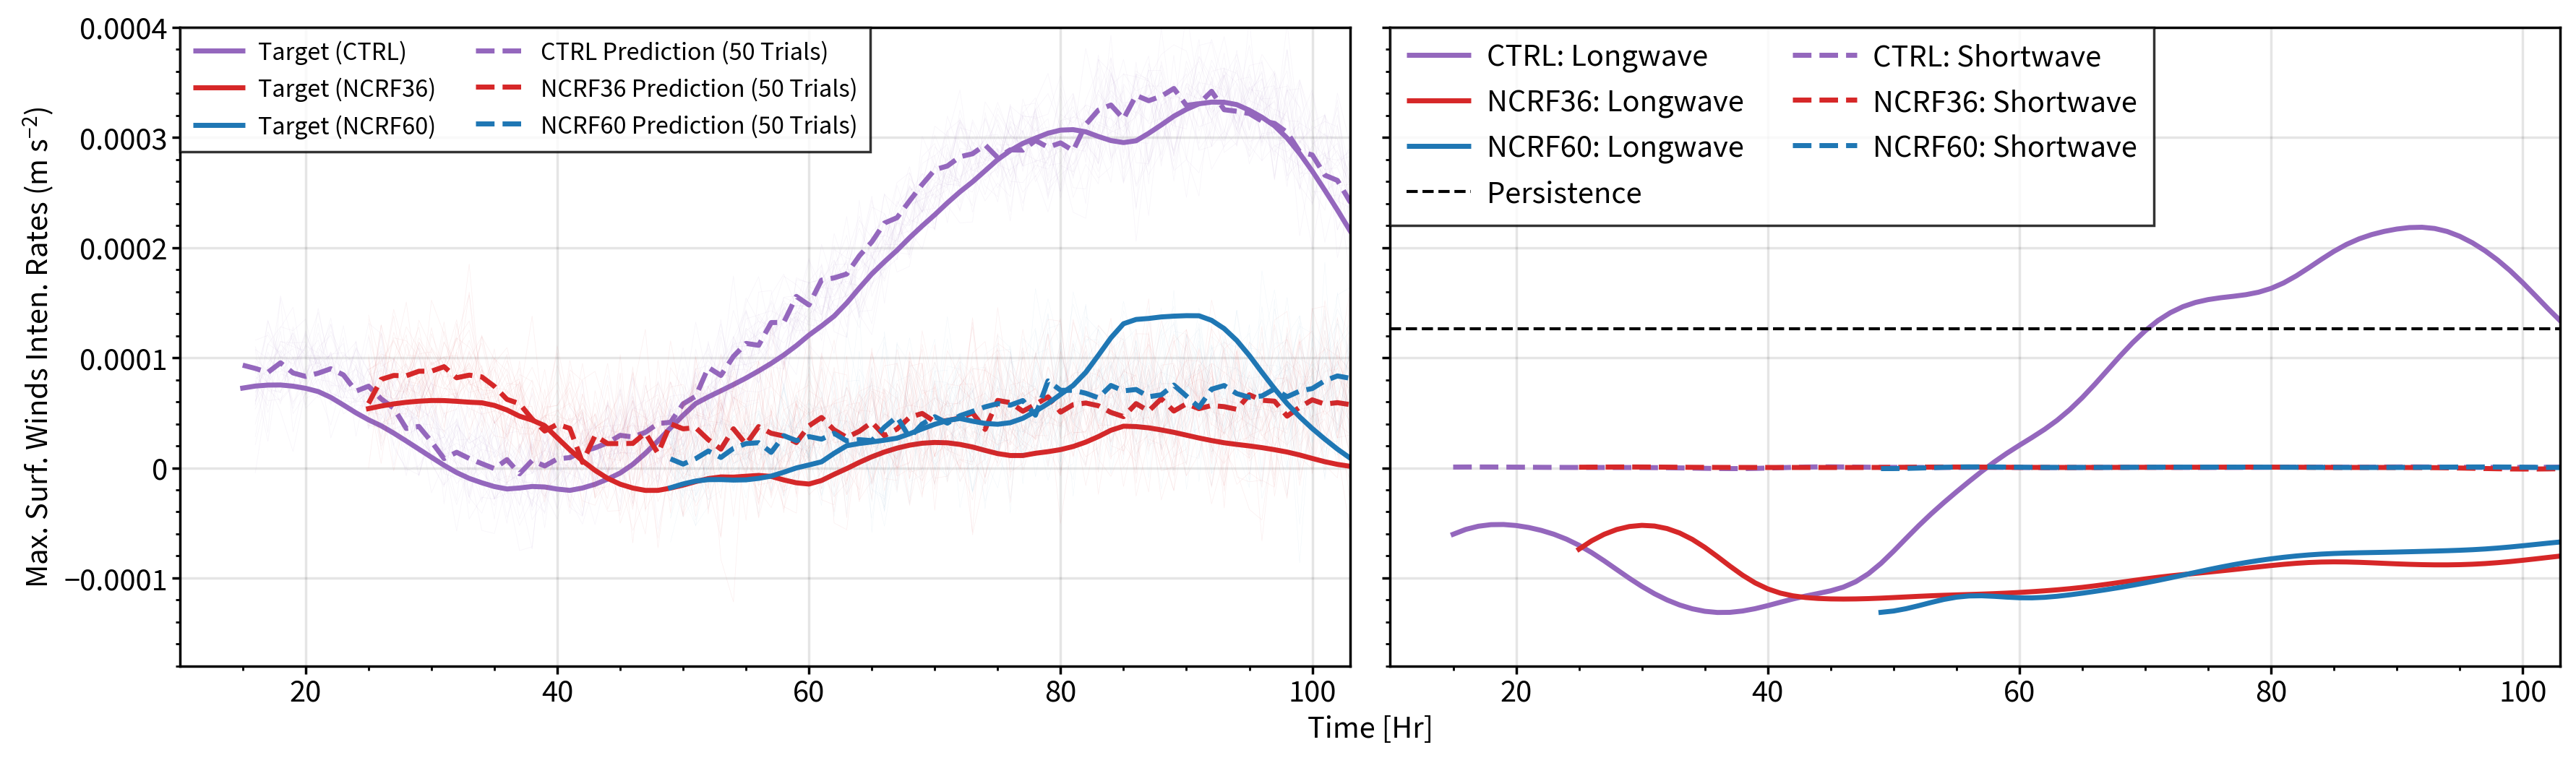

In [81]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.85
r2_performance = seeds_store[seeds[minseed]]
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=8.095,refaspect=1.831,share=3)
axs[0].plot(np.linspace(15,15+96-1,96),store_notensor[minsplit]['train'][1][0:96],label=f'Target (CTRL)',c='tab:purple',lw=2.5)#79:132])
axs[0].plot(np.linspace(15,15+96-1,96),r2_performance[accesscode][int(minsplit)]['meantrains'][int(minmodel)][0:96],label='CTRL Prediction (50 Trials)',c='tab:purple',lw=2.5,ls='--')#79:132])

allpreds = r2_performance[accesscode][int(minsplit)]['alltrains'][int(minmodel)]
for pred in allpreds:
    axs[0].plot(np.linspace(16,16+96-1,96),pred[0:96],c='tab:purple',lw=0.25,alpha=0.075)
axs[0].format(xlabel='Time [Hr]',ylabel='Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00018,0.0004],xlim=[10,118-15])

axs[0].plot(np.linspace((25),(25)+96-1,96),store_notensor[minsplit]['test'][1],label=f'Target (NCRF36)',c='tab:red',lw=2.5)#79:132])
axs[0].plot(np.linspace((25),(25)+96-1,96),r2_performance[accesscode][int(minsplit)]['meantests'][int(minmodel)],label='NCRF36 Prediction (50 Trials)',c='tab:red',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(minsplit)]['alltests'][int(minmodel)]
for pred in allpreds:
    axs[0].plot(np.linspace((25),(25)+96-1,96),pred,c='tab:red',lw=0.25,alpha=0.075)
    
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),store_notensor[minsplit]['train'][1][(118-24):(118-24)+(96-24)],label=f'Target (NCRF60)',c='tab:blue',lw=2.5)#79:132])
axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),r2_performance[accesscode][int(minsplit)]['meantrains'][int(minmodel)][(118-24):(118-24)+(96-24)],label='NCRF60 Prediction (50 Trials)',c='tab:blue',lw=2.5,ls='--')#79:132])
allpreds = r2_performance[accesscode][int(minsplit)]['alltrains'][int(minmodel)]
for pred in allpreds:
    axs[0].plot(np.linspace((49),(49)+96-24-1,96-24),pred[(118-24):(118-24)+(96-24)],c='tab:blue',lw=0.15,alpha=0.075)
axs[0].legend(loc=2,ncols=2,prop={'size':13})


axs[1].plot(np.linspace(15,15+96-1,96),ALW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-20:-10],fl)[0:96],label='CTRL: Longwave',c='tab:purple',lw=2.5)#79:132])
axs[1].plot(np.linspace(15,15+96-1,96),ASW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-10:],flsw)[0:96],label='CTRL: Shortwave',c='tab:purple',lw=2.5,ls='--')
axs[1].plot(np.linspace((25),(25)+96-1,96),ALW*np.dot(np.asarray(store_notensor[minsplit]['test'][0])[:,-20:-10],fl),label='NCRF36: Longwave',c='tab:red',lw=2.5)#79:132])
axs[1].plot(np.linspace((25),(25)+96-1,96),ASW*np.dot(np.asarray(store_notensor[minsplit]['test'][0])[:,-10:],flsw),label='NCRF36: Shortwave',c='tab:red',lw=2.5,ls='--')
axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ALW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-20:-10],fl)[(118-24):(118-24)+(96-24)],label='NCRF60: Longwave',c='tab:blue',lw=2.5)#79:132])
axs[1].plot(np.linspace((49),(49)+96-24-1,96-24),ASW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-10:],flsw)[(118-24):(118-24)+(96-24)],label='NCRF60: Shortwave',c='tab:blue',lw=2.5,ls='--')

axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
axs[1].legend(loc=2,ncols=2)
axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00018,0.0004],xlim=[10,118-15])
plt.savefig('../figures/paper_fig2_maria_revised_ved.png',dpi=600)
plt.show()